In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.enable_v2_behavior
# Import tensornetwork
import tensornetwork as tn
# Set the backend to tesorflow
# (default is numpy)
tn.set_default_backend("tensorflow")

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data("/hpc/group/carin/fk43/FanjieKong/Megapixels/new_tfquantum/quantum/TensorNetwork/mnist.npz")

In [3]:
from tensorflow.keras.utils import to_categorical

x_train = x_train.reshape((60000, 28, 28, 1)).astype(np.float32)
y_train = to_categorical(y_train, 10).astype(np.float32)
x_test = x_test.reshape((10000, 28, 28, 1))
y_test = to_categorical(y_test, 10)

# print(x_train.shape, y_train.shape)
# print(x_test.shape, y_test.shape)
# print(y_train)

In [19]:
y_train.shape

(60000, 10)

In [4]:
xx_train = (tf.image.resize(x_train, [16,16]).numpy()-128)/255
xx_test = (tf.image.resize(x_test, [16,16]).numpy()-128)/255

xxx_train = (x_train-128)/255
xxx_test = (x_test-128)/255

In [15]:
class Grid4DMERA(tf.keras.layers.Layer):
    
    def __init__(self, input_dim, bond_dims, output_dims, n_layers=None):
        super(Grid4DMERA, self).__init__()
        # Create the variables for the layer.
        # In this case, the input tensor is (, 1936), we factorize it into a tensor (, 11, 11, 16)
        # first_dim: output shape?
        # second_dim: connect with data tensor
        # third_dim: inter-connect
        if n_layers is None:
            n_layers = np.floor(np.log2(input_dim))
        self.n_layers = n_layers
        in_dims = 16
        dims = input_dim
        self.entanglers = []
        self.isometries= []
            
        # isometries
        self.isometries1 = [tf.Variable(tf.random.normal(shape=(in_dims, in_dims, in_dims, 
                                                                            in_dims, bond_dims)
                                                                     , stddev=1.0/1000),
                                            trainable=True) for j in range(4)]
        
        self.isometries2 = tf.Variable(tf.random.normal(shape=(bond_dims, bond_dims, bond_dims, 
                                                                            bond_dims, output_dims)
                                                                     , stddev=1.0/1000),
                                            trainable=True)

        #print(self.final_mps.shape)
        self.bias = tf.Variable(tf.zeros(shape=(output_dims,)), name="bias", trainable=True)


    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        def f(input_vec, isometries1, isometries2, bias_var, n_layers):
            input_vv = []
            #print(input_vec)
            for i in range(4):
                for ii in range(4):
                    input_vv.append(tf.reshape(input_vec[i*4:i*4+4, ii*4:ii*4+4, 0], (1, 16)))
            input_vec = tf.concat(input_vv, axis=0)
            input_vec = tf.reshape(input_vec, (16, 16))
            input_vec = tf.unstack(input_vec)
            input_nodes = []
            for e_iv in input_vec:
                input_nodes.append(tn.Node(e_iv))
            
                
                                     
            isometries_nodes1 = []
            for eiso in isometries1:
                isometries_nodes1.append(tn.Node(eiso))
            isometries_nodes2 = tn.Node(isometries2)
            
             
            
            input_nodes[0][0] ^ isometries_nodes1[0][0]
            input_nodes[1][0] ^ isometries_nodes1[0][1]
            input_nodes[4][0] ^ isometries_nodes1[0][2]
            input_nodes[5][0] ^ isometries_nodes1[0][3]

            input_nodes[2][0] ^ isometries_nodes1[1][0]
            input_nodes[3][0] ^ isometries_nodes1[1][1]
            input_nodes[6][0] ^ isometries_nodes1[1][2]
            input_nodes[7][0] ^ isometries_nodes1[1][3]
            
            input_nodes[8][0] ^ isometries_nodes1[2][0]         
            input_nodes[9][0] ^ isometries_nodes1[2][1]
            input_nodes[12][0] ^ isometries_nodes1[2][2]
            input_nodes[13][0] ^ isometries_nodes1[2][3]
            
            input_nodes[10][0] ^ isometries_nodes1[3][0]
            input_nodes[11][0] ^ isometries_nodes1[3][1]
            input_nodes[14][0] ^ isometries_nodes1[3][2]
            input_nodes[15][0] ^ isometries_nodes1[3][3]
            
            
            isometries_nodes1[0][4] ^ isometries_nodes2[0]
            isometries_nodes1[1][4] ^ isometries_nodes2[1]
            isometries_nodes1[2][4] ^ isometries_nodes2[2]
            isometries_nodes1[3][4] ^ isometries_nodes2[3]
                            
            nodes = tn.reachable(isometries_nodes2)
            result = tn.contractors.greedy(nodes)
            result = result.tensor
            #print(result)
            #result = (c @ b).tensor
            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        output = tf.vectorized_map(lambda vec: f(vec, self.isometries1,  self.isometries2, self.bias, self.n_layers), inputs)
        return tf.reshape(output, (-1, 10))

In [16]:
Dense = tf.keras.layers.Dense

MERA_model = tf.keras.Sequential()
MERA_model.add(tf.keras.Input(shape=(16,16,1)))
MERA_model.add(Grid4DMERA(input_dim=8, bond_dims=2, output_dims=10, n_layers=2))
#MERA_model.add(Dense(10, activation='softmax', name='fc'))
MERA_model.add(tf.keras.layers.Softmax())
#MERA_model.build(input_shape=(None, 8, 8, 1))
MERA_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
grid4dmera (Grid4DMERA)      (None, 10)                524458    
_________________________________________________________________
softmax (Softmax)            (None, 10)                0         
Total params: 524,458
Trainable params: 524,458
Non-trainable params: 0
_________________________________________________________________


In [17]:
%%time

# TensorNetwork model
MERA_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
MERA_hist = MERA_model.fit(xx_train, y_train, epochs=50, verbose=1)

Train on 60000 samples
Epoch 1/50
 7072/60000 [==>...........................] - ETA: 33s - loss: 2.3232 - accuracy: 0.1441

KeyboardInterrupt: 

In [13]:
# TN model
MERA_model.evaluate(x=xx_test, y=y_test)

10000/10000 [==============================] - 2s 225us/sample - loss: 1.1063 - accuracy: 0.7258


[1.1063085706710816, 0.7258]

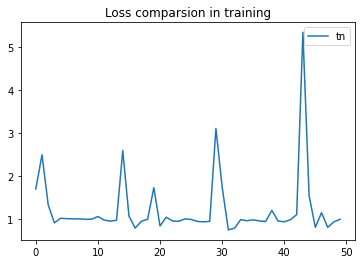

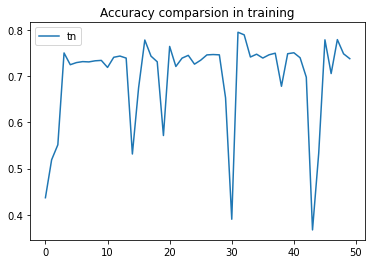

In [16]:
#loss = hist.history['loss']
#acc = hist.history['accuracy']
tn_loss = MERA_hist.history['loss']
tn_acc = MERA_hist.history['accuracy']

#plt.plot(loss, label='traditional')
plt.plot(tn_loss, label='tn')
plt.title('Loss comparsion in training')
#plt.ylim(0, 0.15)
plt.legend()
plt.show()

#plt.plot(acc, label='traditional')
plt.plot(tn_acc, label='tn')
plt.title('Accuracy comparsion in training')
plt.legend()
plt.show()

In [22]:
from tensorflow.keras.utils import Sequence
import pandas as pd
import os 
class ClutteredMNISTDataset(Sequence):
    reg_dataset_size = 11276

    def __init__(self, base_path, csv_path, data_scaling=1., num_examples=None, balance=None, num_classes=2):
        self.base_path = base_path
        self.csv_path = csv_path
        self.csv = pd.read_csv(csv_path)
        self.data_scaling = data_scaling
        self.num_examples = num_examples
        self.balance = balance
        self.num_classes = num_classes
        self.img_paths = self.csv['img_path'].values
        self.lbls = self.csv['label'].values.astype(np.int32)
        self.weights = np.ones([len(self.img_paths), ])

        if self.num_examples is not None and self.balance is not None:
            # only rebalance if examples and balance is given
            assert self.num_examples <= len(self.img_paths), \
                'not enough examples in dataset {} - {}'.format(self.num_examples, len(self.img_paths))

            pos_num = int(self.balance * self.num_examples)
            neg_num = self.num_examples - pos_num

            pos_mask = (self.lbls == 1)
            pos_paths = self.img_paths[pos_mask][:pos_num]

            neg_mask = (self.lbls == 0)
            neg_paths = self.img_paths[neg_mask][:neg_num]

            self.img_paths = np.concatenate([pos_paths, neg_paths], 0)
            self.lbls = np.concatenate([np.ones([pos_num, ]), np.zeros([neg_num, ])], 0)
            self.weights = np.ones([self.num_examples, ])
            self.weights[:pos_num] /= pos_num
            self.weights[pos_num:] /= neg_num

        self.shrinkage = self.reg_dataset_size // len(self.img_paths)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        path = os.path.join(self.base_path, self.img_paths[index])
        lbl = self.lbls[index].astype(np.int64)
        lbl = np.eye(self.num_classes)[lbl].astype(np.int64)
        img = np.load(path)
        if isinstance(img, np.lib.npyio.NpzFile):
            img = img['arr_0']

        if self.data_scaling != 1.:
            img = zoom(img, self.data_scaling)
            img = img.clip(0., 1.)

        img = img[:,:,np.newaxis].astype(np.float32) * 2 - 1

        return img, lbl

In [23]:
class Batcher(Sequence):
    """Assemble a sequence of things into a sequence of batches."""
    def __init__(self, sequence, batch_size=16):
        self._batch_size = batch_size
        self._sequence = sequence
        self._idxs = np.arange(len(self._sequence))

    def __len__(self):
        return int(np.ceil(len(self._sequence) / self._batch_size))

    def __getitem__(self, i):
        if i >= len(self):
            raise IndexError("Index out of bounds")

        start = i*self._batch_size
        end = min(len(self._sequence), start+self._batch_size)
        data = [self._sequence[j] for j in self._idxs[start:end]]
        inputs = [d[0] for d in data]
        outputs = [d[1] for d in data]

        return self._stack(inputs), self._stack(outputs)

    def _stack(self, data):
        if data is None:
            return None

        if not isinstance(data[0], (list, tuple)):
            return np.stack(data)

        seq = type(data[0])
        K = len(data[0])
        data = seq(
            np.stack([d[k] for d in data])
            for k in range(K)
        )

        return data

    def on_epoch_end(self):
        np.random.shuffle(self._idxs)
        self._sequence.on_epoch_end()

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.compat.v1.enable_v2_behavior
# Import tensornetwork
import tensornetwork as tn
from tensorflow.keras.utils import to_categorical
tn.set_default_backend("tensorflow")

data_path = '/datacommons/carin/fk43/NeedleinHaystack/mnist64/'
train_data=ClutteredMNISTDataset(base_path=data_path, csv_path=os.path.join(data_path, 'train.csv'), data_scaling=1., num_examples=3000, balance=0.5)
val_data = ClutteredMNISTDataset(base_path=data_path, csv_path=os.path.join(data_path, 'val.csv'), data_scaling=1., num_examples=1000, balance=0.5)
test_data = ClutteredMNISTDataset(base_path=data_path, csv_path=os.path.join(data_path, 'test.csv'), data_scaling=1., num_examples=1000, balance=0.5)

In [25]:
train_data.__getitem__(1)[0].shape

(64, 64, 1)

In [29]:
np.max(train_data.__getitem__(1500)[0])

1.0

In [27]:
train_data.__getitem__(1500)[0].sum()

-3629.3413

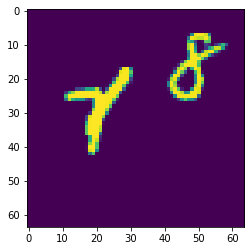

In [28]:
plt.imshow(train_data.__getitem__(1500)[0])

In [8]:
train_data.__getitem__(2000)[1]

array([1, 0])

In [9]:
train_data = Batcher(train_data, batch_size=5)
val_data = Batcher(val_data, batch_size=5)
test_data = Batcher(test_data, batch_size=5)

In [39]:
dir(train_data)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_batch_size',
 '_idxs',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_sequence',
 '_stack',
 'on_epoch_end']

In [40]:
train_data.__getitem__(0)[0].shape

(5, 64, 64, 1)

In [41]:
train_data.__getitem__(0)[1]

array([[0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1]])

In [42]:
class GridMERAin16(tf.keras.layers.Layer):
    
    def __init__(self, kernel_dims, bond_dims, output_dims):
        super(GridMERAin16, self).__init__()
        # Create the variables for the layer.
        # In this case, the input tensor is (, 1936), we factorize it into a tensor (, 11, 11, 16)
        # first_dim: output shape?
        # second_dim: connect with data tensor
        # third_dim: inter-connect
        in_dims = int((kernel_dims//4)**2)
        self.entanglers = []
        self.isometries= []
        self.kernel_dims = kernel_dims
        self.output_dims = output_dims
        #entanglers
        self.entanglers1 = tf.Variable(tf.random.normal
                                             (shape=(in_dims, in_dims, 
                                                     in_dims, in_dims, bond_dims, bond_dims, bond_dims, bond_dims),
                                              stddev=1.0/10000), 
                                              trainable=True)
        self.entanglers2 = tf.Variable(tf.random.normal
                                             (shape=(bond_dims, bond_dims, 
                                                     bond_dims, bond_dims, bond_dims, bond_dims, bond_dims, bond_dims),
                                              stddev=1.0/10000), 
                                              trainable=True)
        # isometries
        self.isometries1 = [tf.Variable(tf.random.normal(shape=(in_dims, in_dims, in_dims, 
                                                                            bond_dims, bond_dims)
                                                                     , stddev=1.0/10*10000),
                                            trainable=True), 
                           tf.Variable(tf.random.normal(shape=(in_dims, in_dims, bond_dims, 
                                                                            in_dims, bond_dims)
                                                                     , stddev=1.0/10*10000),
                                            trainable=True),
                           tf.Variable(tf.random.normal(shape=(in_dims, bond_dims, in_dims, 
                                                                            in_dims, bond_dims)
                                                                     , stddev=1.0/10*10000),
                                            trainable=True),
                           tf.Variable(tf.random.normal(shape=(bond_dims, in_dims, in_dims, 
                                                                            in_dims, bond_dims)
                                                                     , stddev=1.0/10*10000),
                                            trainable=True)]
        
        self.isometries2 = tf.Variable(tf.random.normal(shape=(bond_dims, bond_dims, bond_dims, 
                                                                            bond_dims, output_dims)
                                                                     , stddev=1.0/10*10000),
                                            trainable=True)

        #print(self.final_mps.shape)
        self.bias = tf.Variable(tf.zeros(shape=(output_dims,)), name="bias", trainable=True)


    def call(self, inputs):
        # Define the contraction.
        # We break it out so we can parallelize a batch using tf.vectorized_map.
        def f(input_vec, entanglers1, entanglers2, isometries1, isometries2, bias_var, kernel_dims):
            input_vv = []
            step = int(kernel_dims//4)
            for i in range(4):
                for ii in range(4):
                    input_vv.append(tf.reshape(input_vec[i*step:i*step+step, ii*step:ii*step+step, 0], (1, step**2)))
            input_vec = tf.concat(input_vv, axis=0)
            input_vec = tf.reshape(input_vec, (16, step**2))
            input_vec = tf.unstack(input_vec)
            input_nodes = []
            for e_iv in input_vec:
                input_nodes.append(tn.Node(e_iv))
            
            e_nodes1 = tn.Node(entanglers1)
            e_nodes2 = tn.Node(entanglers2)
                
                                     
            isometries_nodes1 = []
            for eiso in isometries1:
                isometries_nodes1.append(tn.Node(eiso))
            isometries_nodes2 = tn.Node(isometries2)
            
            
            e_nodes1[0] ^ input_nodes[5][0]
            e_nodes1[1] ^ input_nodes[6][0]
            e_nodes1[2] ^ input_nodes[9][0]
            e_nodes1[3] ^ input_nodes[10][0]

            e_nodes1[4] ^ isometries_nodes1[0][3]
            e_nodes1[5] ^ isometries_nodes1[1][2]
            e_nodes1[6] ^ isometries_nodes1[2][1]
            e_nodes1[7] ^ isometries_nodes1[3][0]     
            
            input_nodes[0][0] ^ isometries_nodes1[0][0]
            input_nodes[1][0] ^ isometries_nodes1[0][1]
            input_nodes[4][0] ^ isometries_nodes1[0][2]
            
            input_nodes[2][0] ^ isometries_nodes1[1][0]
            input_nodes[3][0] ^ isometries_nodes1[1][1]
            input_nodes[7][0] ^ isometries_nodes1[1][3]
            
            input_nodes[8][0] ^ isometries_nodes1[2][0]
            input_nodes[12][0] ^ isometries_nodes1[2][2]
            input_nodes[13][0] ^ isometries_nodes1[2][3]
            
            input_nodes[11][0] ^ isometries_nodes1[3][1]
            input_nodes[14][0] ^ isometries_nodes1[3][2]
            input_nodes[15][0] ^ isometries_nodes1[3][3]
            
            
            isometries_nodes1[0][4] ^ e_nodes2[0]
            isometries_nodes1[1][4] ^ e_nodes2[1]
            isometries_nodes1[2][4] ^ e_nodes2[2]
            isometries_nodes1[3][4] ^ e_nodes2[3]

            e_nodes2[4] ^ isometries_nodes2[0]
            e_nodes2[5] ^ isometries_nodes2[1]
            e_nodes2[6] ^ isometries_nodes2[2]
            e_nodes2[7] ^ isometries_nodes2[3]

                            
            nodes = tn.reachable(isometries_nodes2)
            result = tn.contractors.greedy(nodes)
            result = result.tensor
            #print(result)
            #result = (c @ b).tensor
            # Finally, add bias.
            return result + bias_var

        # To deal with a batch of items, we can use the tf.vectorized_map function.
        # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
        output = tf.vectorized_map(lambda vec: f(vec, self.entanglers1, self.entanglers2,
                                                 self.isometries1,  self.isometries2, self.bias, self.kernel_dims), inputs)
        return tf.reshape(output, (-1, self.output_dims))

In [43]:
from tensorflow.keras.layers import Lambda, Input, Concatenate, Reshape, Softmax
from tensorflow.keras.models import Model, Sequential

def get_model(input_shape=(64, 64, 1)):
    x_in = Input(shape=input_shape)
    x_out_list = []
    for i in range(8):
        for j in range(8):
            subx = Lambda(lambda x:x[:, 8*i:8*(i+1),8*j:8*(j+1),:] )(x_in)
            x_out_list.append(GridMERAin16(kernel_dims=8, bond_dims=2, output_dims=1)(subx))
    x_out = Concatenate(axis=1)(x_out_list)
    x_out = Reshape(target_shape=(8, 8, 1))(x_out)
    y = GridMERAin16(kernel_dims=8, bond_dims=2, output_dims=2)(x_out)
    y = Softmax()(y)
    return Model(inputs=x_in, outputs=y)

In [1]:
def get_deep_model(input_shape=(64, 64, 1)):
    x_in = Input(shape=input_shape)
    x_in2_list = []
    for i in range(16):
        for j in range(16):
            subx = Lambda(lambda x:x[:, 4*i:4*(i+1),4*j:4*(j+1),:] )(x_in)
            x_in2_list.append(GridMERAin16(kernel_dims=1, bond_dims=2, output_dims=1)(subx))
    x_in2 = Concatenate(axis=1)(x_out_list)
    x_in2 = Reshape(target_shape=(16, 16, 1))(x_in2)
    x_out_list = []
    for i in range(4):
        for j in range(4):
            subx = Lambda(lambda x:x[:, 4*i:4*(i+1),4*j:4*(j+1),:] )(x_in2)
            x_out_list.append(GridMERAin16(kernel_dims=1, bond_dims=2, output_dims=1)(subx))
    x_out = Concatenate(axis=1)(x_out_list)
    x_out = Reshape(target_shape=(4, 4, 1))(x_out)
    y = GridMERAin16(kernel_dims=1, bond_dims=2, output_dims=2)(x_out)
    y = Softmax()(y)
    return Model(inputs=x_in, outputs=y)

In [44]:
MERA_model_64 = get_model(input_shape=(64, 64, 1))

In [45]:
MERA_model_64.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 8, 8, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 8, 8, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 8, 8, 1)      0           input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
%%time

# TensorNetwork model
MERA_model_64.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
MERA_model_64_hist = MERA_model_64.fit_generator(train_data, validation_data=val_data, epochs=50, verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 600 steps, validate for 200 steps
Epoch 1/50


In [17]:
# ReadMNIST64
import os
import torch
import argparse
import numpy as np
from data.cluttered_mnist.dataset import ClutteredMNISTDataset
from train import train


def get_datasets(data_path, data_scaling, data_balance, batch_size, num_examples):
    dataset = ClutteredMNISTDataset

    train_dataset = dataset(data_path, os.path.join(data_path, 'train.csv'),
                            data_scaling, num_examples, data_balance)

    weights = torch.Tensor(train_dataset.weights)
    # over and undersamples..
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(train_dataset))

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, num_workers=8, sampler=sampler, pin_memory=True)
    train_val_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

    val_dataset = dataset(data_path, os.path.join(data_path, 'val.csv'), data_scaling)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

    test_dataset = dataset(data_path, os.path.join(data_path, 'test.csv'), data_scaling)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, num_workers=8, shuffle=False)

    return train_loader, train_val_loader, val_loader, test_loader

ModuleNotFoundError: No module named 'torch'

In [ ]:
import numpy as np
import keras

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('data/' + ID + '.npy')

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)